In [15]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt


class GaussianApproximator:
    def __init__(self, initial_params, zeta):
        self.n_gaussians = len(initial_params) // 3
        self.zeta = zeta
        self.params = initial_params
        self.bounds = [(0, 10), (-1, 1), (-1, 1)] * self.n_gaussians  # パラメータの範囲

    @staticmethod
    def phi_1s(zeta_1, r):
        return (zeta_1**3 / np.pi) ** 0.5 * np.exp(-zeta_1 * r)

    @staticmethod
    def phi_2s(zeta_2, r):
        return (zeta_2**5 / (3 * np.pi)) ** 0.5 * r * np.exp(-zeta_2 * r)

    @staticmethod
    def phi_2p(zeta_2, r, theta=0):  # thetaのデフォルト値を0に設定
        return (zeta_2**5 / np.pi) ** 0.5 * r * np.exp(-zeta_2 * r) * np.cos(theta)

    @staticmethod
    def phi_g1s(alpha, r):
        return (2 * alpha / np.pi) ** (3 / 4) * np.exp(-alpha * r**2)

    @staticmethod
    def phi_g2p(alpha, r):
        return (128 * alpha**5 / np.pi**3) ** (1 / 4) * r * np.exp(-alpha * r**2)

    def phi_approx_g1s(self, params, r):
        sum_phi = 0
        for i in range(self.n_gaussians):
            alpha = params[3 * i]
            c1s = params[3 * i + 1]
            sum_phi += c1s * self.phi_g1s(alpha, r)
        return sum_phi

    def phi_approx_g2p(self, params, r):
        sum_phi = 0
        for i in range(self.n_gaussians):
            alpha = params[3 * i]
            c2p = params[3 * i + 2]
            sum_phi += c2p * self.phi_g2p(alpha, r)
        return sum_phi

    def integrand(self, r, params):
        return (
            np.abs(self.phi_approx_g1s(params, r) - self.phi_2s(self.zeta, r)) ** 2
            * 4
            * np.pi
            * r**2
            + np.abs(self.phi_approx_g2p(params, r) - self.phi_2p(self.zeta, r)) ** 2
            * 4
            * np.pi
            * r**2
            / 3
        )

    def objective_function(self, params):
        integral, error = quad(self.integrand, 0, np.inf, args=(params,))
        return integral

    def normalization_constraint_2s(self, params):
        integral, error = quad(
            lambda r: self.phi_approx_g1s(params, r) ** 2 * 4 * np.pi * r**2, 0, np.inf
        )
        return integral - 1

    def normalization_constraint_2p(self, params):
        integral, error = quad(
            lambda r: self.phi_approx_g2p(params, r) ** 2 * 4 * np.pi * r**2 / 3,
            0,
            np.inf,
        )
        return integral - 1

    def optimize(self):
        constraints = [
            {"type": "eq", "fun": self.normalization_constraint_2s},
            {"type": "eq", "fun": self.normalization_constraint_2p},
        ]
        result = minimize(
            self.objective_function,
            self.params,
            bounds=self.bounds,
            constraints=constraints,
        )
        return result

In [16]:
def phi_1s(zeta_1, r):
    return (zeta_1**3 / np.pi) ** 0.5 * np.exp(-zeta_1 * r)


def phi_2s(zeta_2, r):
    return (zeta_2**5 / (3 * np.pi)) ** 0.5 * r * np.exp(-zeta_2 * r)


def phi_2p(zeta_2, r):
    return (zeta_2**5 / np.pi) ** 0.5 * r * np.exp(-zeta_2 * r)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.009074838867047944
       x: [ 3.843e-01  4.942e-02  5.115e-01  9.746e-02  9.638e-01
            6.129e-01]
     nit: 20
     jac: [-1.464e-03  4.060e-03  2.858e-03  4.135e-03  5.602e-03
            3.288e-03]
    nfev: 148
    njev: 20


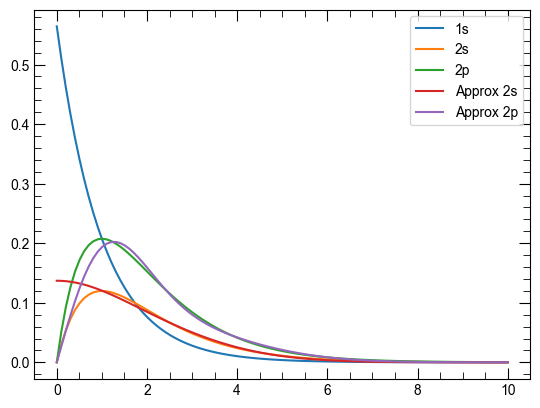

In [17]:
# 初期化
approximator = GaussianApproximator([0.5, 0.5, 0.9, 0.5, 0.9, 0.5], 1)
optimized_params = approximator.optimize()
print(optimized_params)

fig, ax = plt.subplots()
r = np.linspace(0, 10, 100)
y1s = phi_1s(1, r)
y2s = phi_2s(1, r)
y2p = phi_2p(1, r)
y2 = approximator.phi_approx_g1s(optimized_params.x, r)
y3 = approximator.phi_approx_g2p(optimized_params.x, r)

ax.plot(r, y1s, label="1s")
ax.plot(r, y2s, label="2s")
ax.plot(r, y2p, label="2p")
ax.plot(r, y2, label="Approx 2s")
ax.plot(r, y3, label="Approx 2p")
ax.legend()
plt.show()

In [21]:
np.hstack((optimized_params.x, np.array([0.5, 0.5])))

array([0.38430266, 0.04942191, 0.51151802, 0.09745713, 0.96382149,
       0.61286022, 0.5       , 0.5       ])

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.0010033887158006486
       x: [ 9.848e-01 -9.968e-02  1.580e-01  7.483e-02  6.960e-01
            3.880e-01  2.292e-01  4.037e-01  6.094e-01]
     nit: 38
     jac: [-2.885e-05  5.782e-05 -2.710e-04  7.525e-04  7.614e-04
            2.814e-04 -2.355e-03  3.001e-04  5.000e-04]
    nfev: 389
    njev: 38


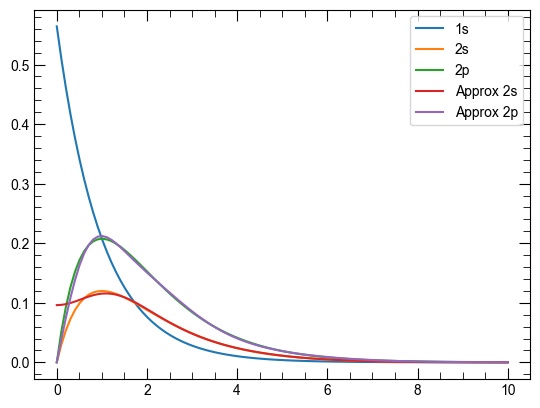

In [23]:
# 初期化
approximator = GaussianApproximator(
    np.hstack((optimized_params.x, np.array([0.5, 0.5, 0.5]))), 1
)
optimized_params = approximator.optimize()
print(optimized_params)

fig, ax = plt.subplots()
r = np.linspace(0, 10, 100)
y1s = phi_1s(1, r)
y2s = phi_2s(1, r)
y2p = phi_2p(1, r)
y2 = approximator.phi_approx_g1s(optimized_params.x, r)
y3 = approximator.phi_approx_g2p(optimized_params.x, r)

ax.plot(r, y1s, label="1s")
ax.plot(r, y2s, label="2s")
ax.plot(r, y2p, label="2p")
ax.plot(r, y2, label="Approx 2s")
ax.plot(r, y3, label="Approx 2p")
ax.legend()
plt.show()